# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [22]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [23]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con)
filtered_data_5k = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con)

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [24]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [25]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [26]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [27]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [28]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [29]:
#Sorting data according to ProductId in ascending order
sorted_data_5k=filtered_data_5k.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [30]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final_5k=sorted_data_5k.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [31]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [32]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [33]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final_5k=final_5k[final_5k.HelpfulnessNumerator<=final_5k.HelpfulnessDenominator]

In [34]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)
print(final_5k.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)
(4986, 10)


1    38479
0     7592
Name: Score, dtype: int64

In [35]:
x=final.drop('Score',axis=1)
y=final.filter(['Score'],axis=1)
x_5k=final_5k.drop('Score',axis=1)
y_5k=final_5k.filter(['Score'],axis=1)

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [36]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [37]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [38]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [39]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [40]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...


In [41]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [42]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great flavor low in calories high in nutrients high in protein Usually protein powders are high priced and high in calories this one is a great bargain and tastes great I highly recommend for the lady gym rats probably not macho enough for guys since it is soy based 


In [43]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [44]:
# Combining all the above stundents 
def prepro(x):
    # Combining all the above stundents 
    from tqdm import tqdm
    preprocessed_reviews = []
    # tqdm is for printing the status bar
    for sentance in tqdm(x['Text'].values):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
        preprocessed_reviews.append(sentance.strip())
    return preprocessed_reviews

In [45]:
preprocessed_reviews=prepro(x)

100%|██████████████████████████████████████████████████████████████████████████| 46071/46071 [00:19<00:00, 2358.11it/s]


In [46]:
preprocessed_reviews_5k=prepro(x_5k)

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:01<00:00, 2646.55it/s]


# [4] Featurization

## [4.1] BAG OF WORDS

In [47]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaand']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46071, 39364)
the number of unique words  39364


## [4.2] Bi-Grams and n-Grams.

In [48]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46071, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [49]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy', 'able feed', 'able figure', 'able find']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (46071, 27311)
the number of unique words including both unigrams and bigrams  27311


## [4.4] Word2Vec

In [29]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [30]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=-1)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


[('lethargic', 0.5813351273536682), ('elixir', 0.4882150888442993), ('obedience', 0.4840397238731384), ('sum', 0.47171512246131897), ('increasingly', 0.4604194164276123), ('arises', 0.4573840796947479), ('nuanced', 0.45459675788879395), ('subscribing', 0.4535188674926758), ('neapolitan', 0.448333740234375), ('understatement', 0.44206249713897705)]
[('tribe', 0.48172134160995483), ('baronet', 0.4726521074771881), ('borderline', 0.46643686294555664), ('stingers', 0.46183228492736816), ('step', 0.46122312545776367), ('pediatrician', 0.45832517743110657), ('nut', 0.44819045066833496), ('radish', 0.43946659564971924), ('aftertaste', 0.432195246219635), ('narrower', 0.42854970693588257)]


In [55]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

In [51]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_5k=[]
for sentance in preprocessed_reviews_5k:
    list_of_sentance_5k.append(sentance.split())

In [52]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model_5k=Word2Vec(list_of_sentance_5k,min_count=5,size=50, workers=-1)
    print(w2v_model_5k.wv.most_similar('great'))
    print('='*50)
    print(w2v_model_5k.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


[('compared', 0.45801815390586853), ('made', 0.4361136555671692), ('french', 0.42951273918151855), ('buffalo', 0.42637085914611816), ('zero', 0.4016711115837097), ('friends', 0.3990868628025055), ('cancelled', 0.39709705114364624), ('popping', 0.3946441411972046), ('accessible', 0.3926207423210144), ('fig', 0.38326650857925415)]
[('connect', 0.4780372977256775), ('caramels', 0.43245017528533936), ('gummy', 0.40495651960372925), ('cable', 0.3973364233970642), ('reflux', 0.3939606845378876), ('miracle', 0.38992273807525635), ('relief', 0.38989174365997314), ('huge', 0.36743462085723877), ('couldnt', 0.36736732721328735), ('saved', 0.36147212982177734)]


In [53]:
w2v_words_5k = list(w2v_model_5k.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_5k))
print("sample words ", w2v_words_5k[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [35]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 46071/46071 [01:29<00:00, 517.02it/s]


46071
50


In [54]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_5k = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_5k): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_5k:
            vec = w2v_model_5k.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_5k.append(sent_vec)
print(len(sent_vectors_5k))
print(len(sent_vectors_5k[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:05<00:00, 935.33it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [37]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [38]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 46071/46071 [11:37<00:00, 66.09it/s]


In [39]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model_5k = TfidfVectorizer()
tf_idf_matrix = model_5k.fit_transform(preprocessed_reviews_5k)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model_5k.get_feature_names(), list(model_5k.idf_)))

In [40]:
# TF-IDF weighted Word2Vec
tfidf_feat = model_5k.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_5k = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_5k): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_5k and word in tfidf_feat:
            vec = w2v_model_5k.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_5k.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:21<00:00, 232.93it/s]


In [42]:
# Combining all the above stundents 
def prepro(x):
    # Combining all the above stundents 
    from tqdm import tqdm
    preprocessed_reviews = []
    sentance=x
    # tqdm is for printing the status bar
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())
    return preprocessed_reviews

# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [51]:
from sklearn.cluster import KMeans
import os


In [101]:
error=[]
k=[1,2,3,4,5,6,7,8,9,10,11,12,13,14]
for i in k:
    cluster=KMeans(n_clusters=i,n_jobs=-1)
    cluster.fit(final_counts)
    error.append(cluster.inertia_)

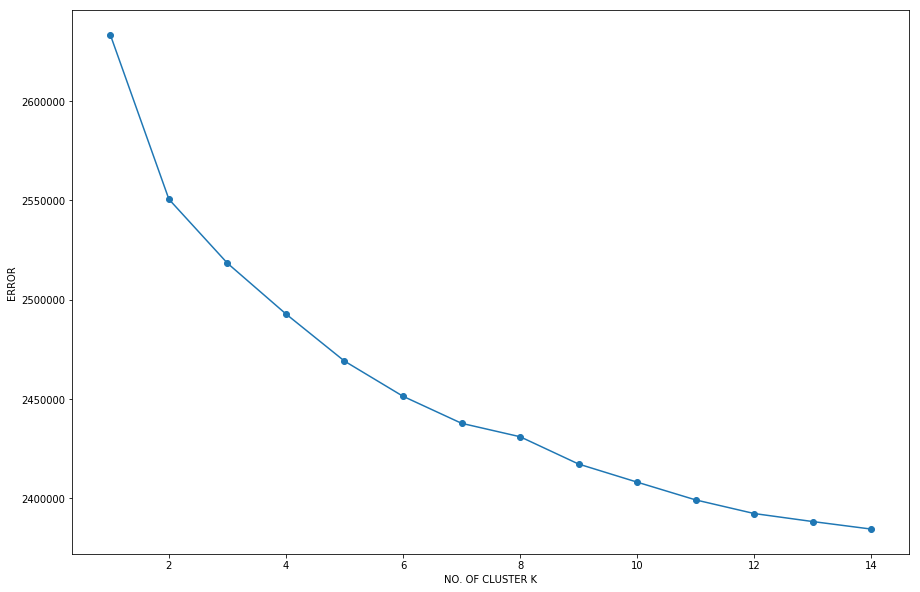

In [45]:
plt.figure(figsize=(15,10))
plt.plot(k,error,'-o')
plt.xlabel('NO. OF CLUSTER K' )
plt.ylabel('ERROR')
plt.show()

In [ ]:
cluster=KMeans(n_clusters=14,n_jobs=-1)
cluster.fit(final_counts)

In [51]:
len(cluster.labels_)

46071

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

In [52]:
centers=cluster.cluster_centers_

In [53]:
features = count_vect.get_feature_names()

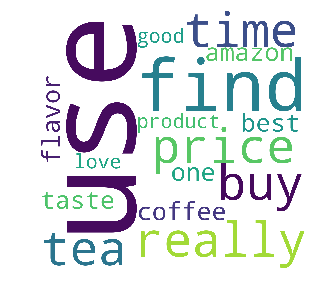

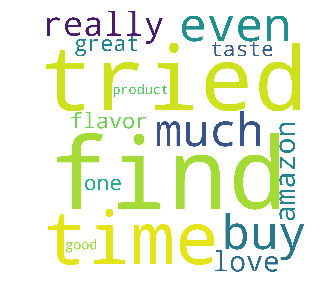

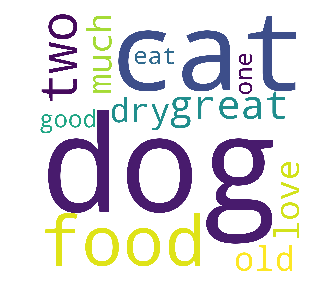

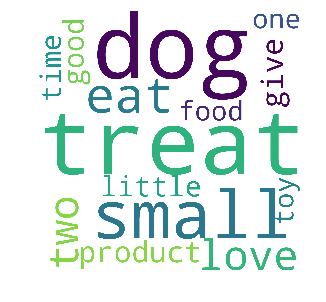

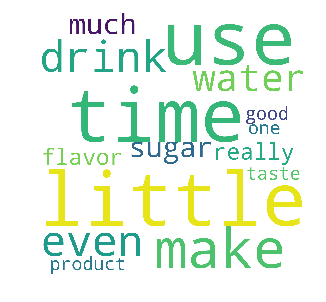

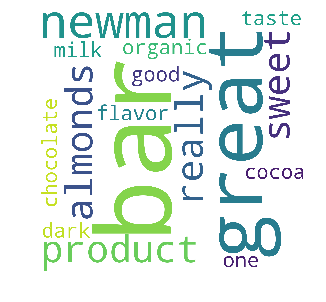

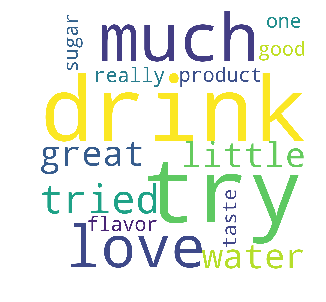

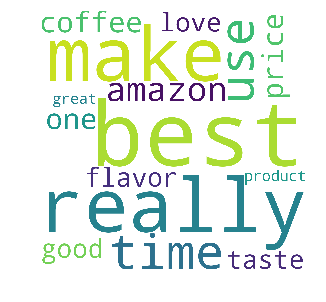

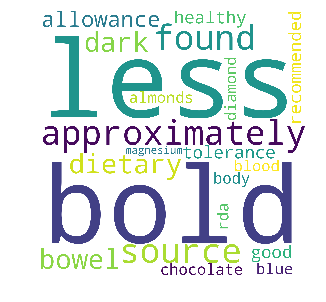

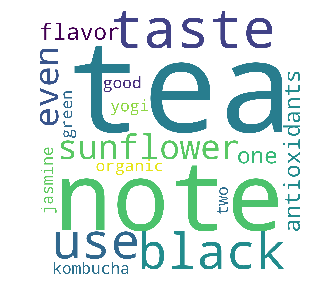

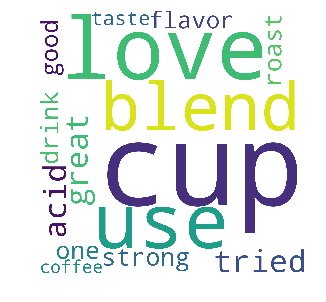

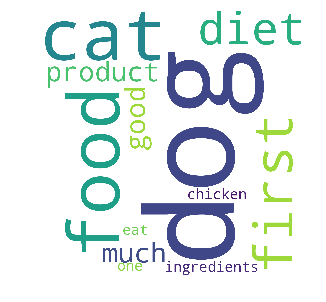

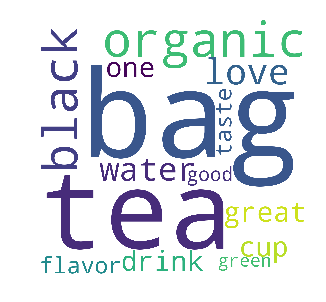

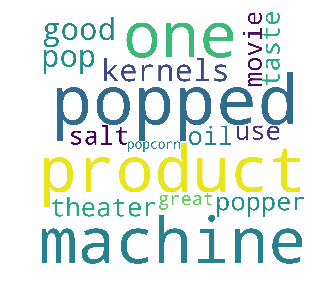

In [54]:

wc=[]
from wordcloud import WordCloud
for i in  range(len(centers)):
    imp1=np.argsort(centers[i])
    s=''
    for j in imp1[-21:]:
        s=s+' '+features[j]
#         print("{0} {1}".format(features[j],centers[i,j]))
    wc=WordCloud(width=1600,height=1600,stopwords=None,\
                       background_color='white',min_font_size=5).generate(s)
    print('WORD CLOOUD FOR CLUSTER ',i)
    plt.figure()
    plt.imshow(wc)
    plt.axis('off')
    plt.tight_layout(pad=0)
    
    plt.show()

<h4> -In the above clusters, we can easily observe that there are some clusters similar to each other.<br>
     -There are also some words which are common in the clusters.<br>
    e.g., Cat, Dog, Product, good, etc.
</h4>

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [35]:
from sklearn.cluster import KMeans
import os


In [52]:
error=[]
k=[1,2,3,4,5,6,7,8,9,10,11]
for i in k:
    cluster=KMeans(n_clusters=i,n_jobs=-1)
    cluster.fit(final_tf_idf)
    error.append(cluster.inertia_)


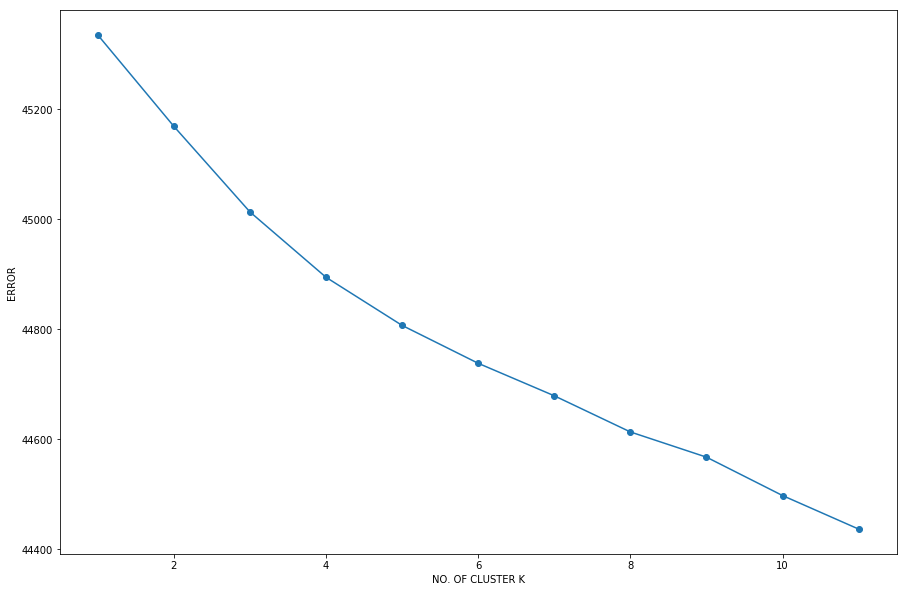

In [57]:
plt.figure(figsize=(15,10))
plt.plot(k,error,'-o')
plt.xlabel('NO. OF CLUSTER K' )
plt.ylabel('ERROR')
plt.show()

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

In [ ]:
cluster=KMeans(n_clusters=11,n_jobs=-1)
cluster.fit(final_tf_idf)

In [37]:
centers=cluster.cluster_centers_

In [38]:
features = tf_idf_vect.get_feature_names()

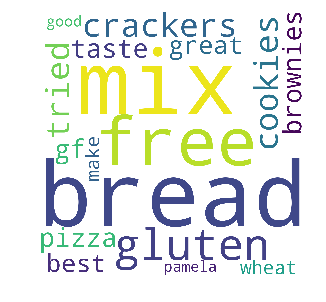

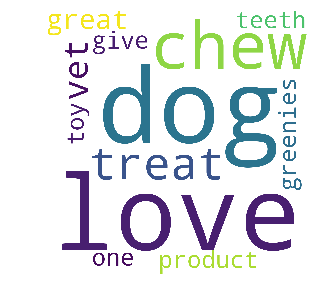

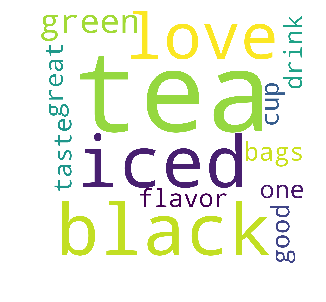

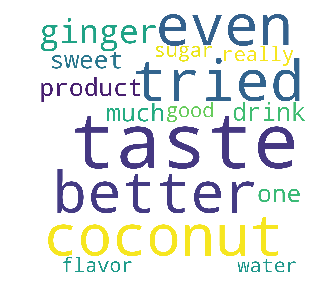

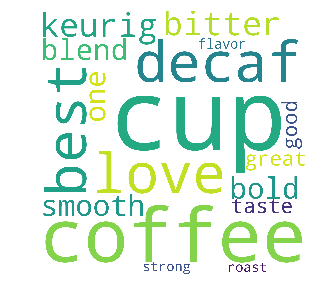

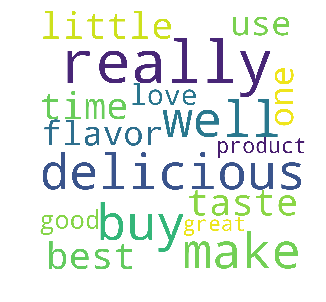

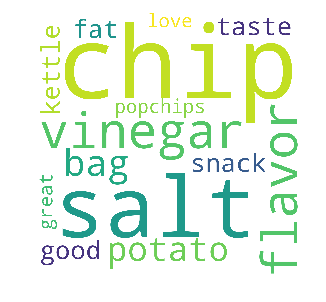

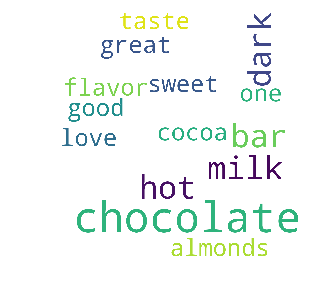

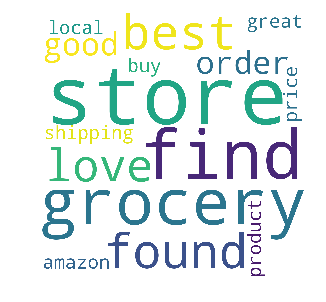

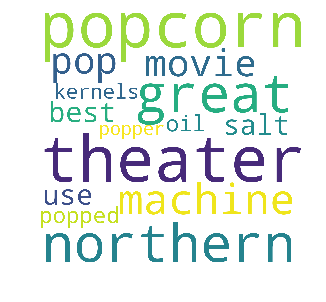

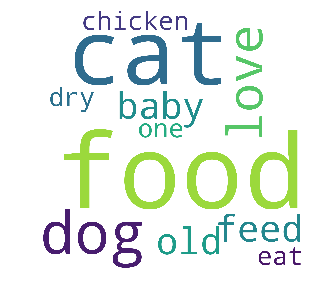

In [39]:

wc=[]
from wordcloud import WordCloud
for i in  range(len(centers)):
    imp1=np.argsort(centers[i])
    s=''
    for j in imp1[-21:]:
        s=s+' '+features[j]
#         print("{0} {1}".format(features[j],centers[i,j]))
    wc=WordCloud(width=1600,height=1600,stopwords=None,\
                       background_color='white',min_font_size=5).generate(s)
    plt.figure()
    plt.imshow(wc)
    plt.axis('off')
    plt.tight_layout(pad=0)
    
    plt.show()

<h4> -In the above clusters, we can easily observe that there are some clusters similar to each other.<br>
     -There are also some words which are common in the clusters.<br>
    e.g., Great, Dog, Cat, Love, great, etc.
</h4>

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

In [44]:
from sklearn.cluster import KMeans
import os


In [35]:
error=[]
k=[1,2,3,4,5,6,7,8,9,10,12,14]
for i in k:
    cluster=KMeans(n_clusters=i,n_jobs=-1)
    cluster.fit(sent_vectors)
    error.append(cluster.inertia_)
    print(i)

1
2
3
4
5
6
7
8
9
10
12
14


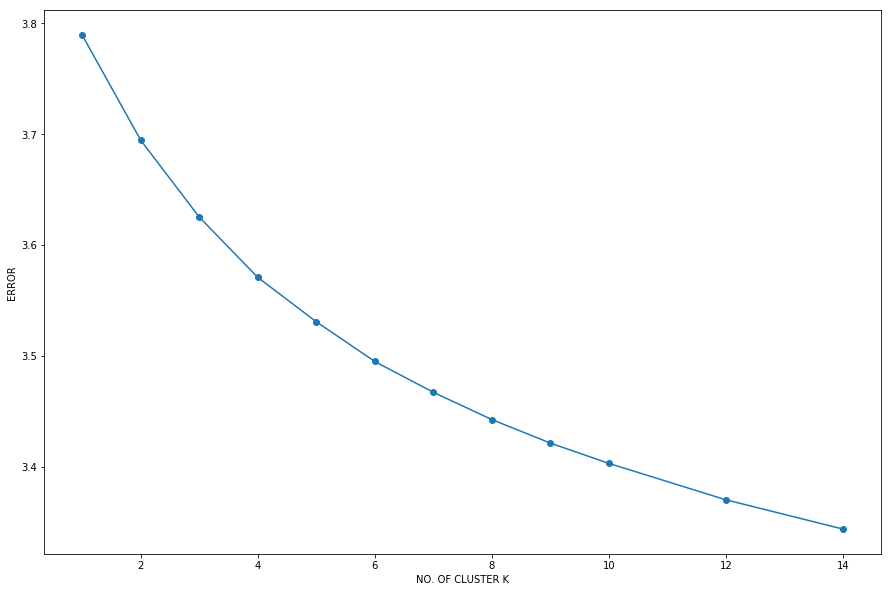

In [36]:
plt.figure(figsize=(15,10))
plt.plot(k,error,'-o')
plt.xlabel('NO. OF CLUSTER K' )
plt.ylabel('ERROR')
plt.show()

In [46]:
len(cluster.labels_)
final["cluster_label"] = cluster.labels_

### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

In [45]:
cluster=KMeans(n_clusters=14,n_jobs=-1)
cluster.fit(sent_vectors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=14, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [46]:
final['labels']=cluster.labels_
groups_cluster=final.filter(['Text','labels'],axis=1)

In [47]:
groups_cluster=groups_cluster.groupby('labels')['Text'].apply(lambda text: ','.join(text))

In [48]:
groups_cluster

labels
0     I read the reviews and was dubious but my dog ...
1     This is the best dog food I ever had<br /><br ...
2     I'm glad my 45lb cocker/standard poodle puppy ...
3     Good flavor, unique in all the teas that I've ...
4     I've used this brand for years. If you're feel...
5     Why is this $[...] when the same product is av...
6     Our dogs just love them.  I saw them in a pet ...
7     This is another favorite in our house.  My cat...
8     My dogs loves this chicken but its a product f...
9     I think 9 Lives does a better job on this vari...
10    This was a really good idea and the final prod...
11    I just received my shipment and could hardly w...
12    At 60 years old I have had the care of cats my...
13    Although I do not buy Canidae through Amazon, ...
Name: Text, dtype: object

In [49]:
for i in range(14):
    groups_cluster[i]=prepro(groups_cluster[i])
    groups_cluster[i]=groups_cluster[i][0]
    

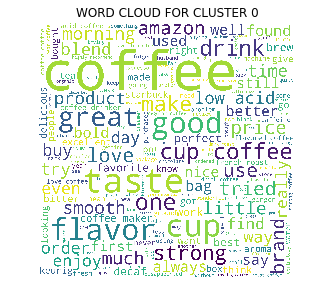

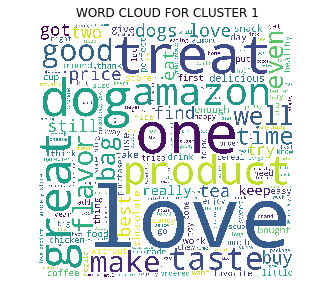

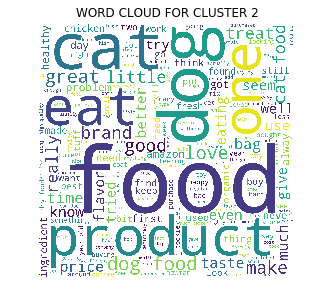

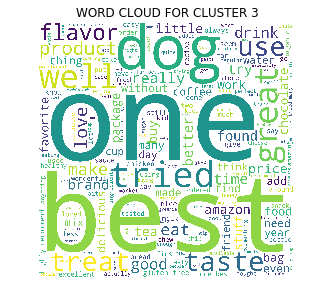

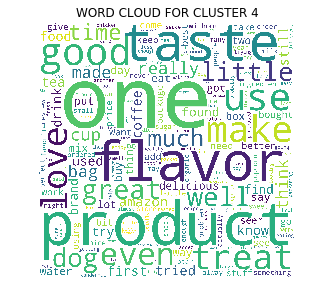

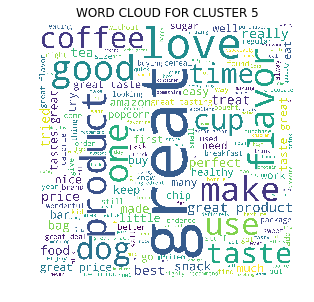

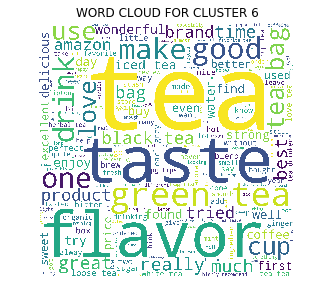

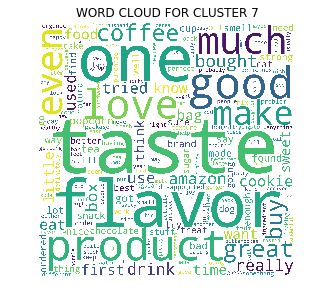

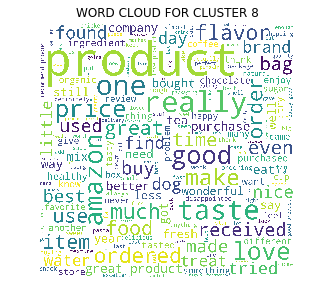

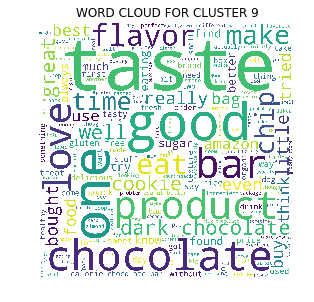

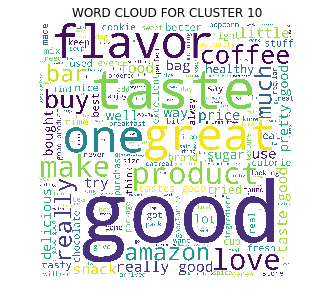

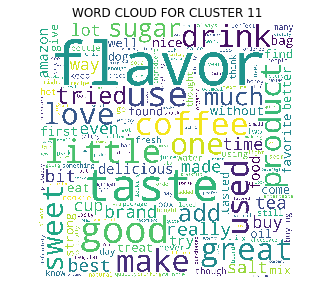

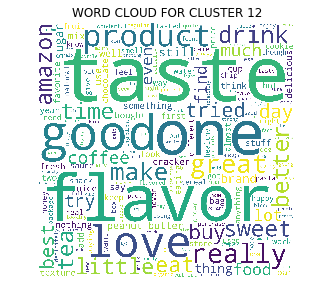

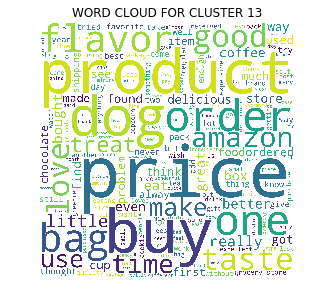

In [50]:
from wordcloud import WordCloud
for i in range(len(groups_cluster)):
    wc=WordCloud(width=4000,height=4000,stopwords=None,\
                           background_color='white',min_font_size=5).generate(groups_cluster[i])
    plt.figure()
    plt.imshow(wc)
    plt.axis('off')
    plt.title('WORD CLOUD FOR CLUSTER '+str(i))
    plt.tight_layout(pad=0)

    plt.show()

<h4> -In the above clusters, we can easily observe that there are some clusters similar to each other.<br>
     -There are also some words which are common in the clusters.<br>
    e.g., Taste, Flavour, D, good, etc.
</h4>

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [36]:
error=[]
k=[1,2,3,4,5,6,7,8,9,10,11,12,13,14]
for i in k:
    cluster=KMeans(n_clusters=i,n_jobs=-1)
    cluster.fit(tfidf_sent_vectors)
    error.append(cluster.inertia_)
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14


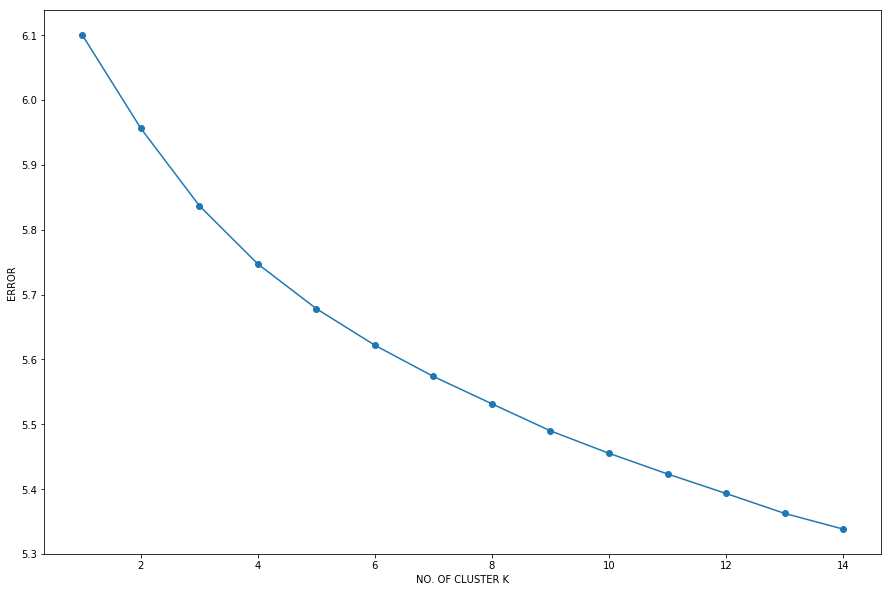

In [37]:
plt.figure(figsize=(15,10))
plt.plot(k,error,'-o')
plt.xlabel('NO. OF CLUSTER K' )
plt.ylabel('ERROR')
plt.show()

### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

In [51]:
cluster=KMeans(n_clusters=14,n_jobs=-1)
cluster.fit(tfidf_sent_vectors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=14, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [52]:
final=final.drop(['labels'],axis=1)

In [53]:
final['labels']=cluster.labels_
groups_cluster=final.filter(['Text','labels'],axis=1)

In [54]:
groups_cluster=groups_cluster.groupby('labels')['Text'].apply(lambda text: ','.join(text))

In [55]:
groups_cluster

labels
0     My dogs loves this chicken but its a product f...
1     I've been trying to find the individual-pack o...
2     Why is this $[...] when the same product is av...
3     This was a really good idea and the final prod...
4     One of the favorite places that I frequent whe...
5     According to my cat, this stuff is just great....
6     These Fancy Feast Variety Packs, which contain...
7     I ordered this as it is the food I always use ...
8     Our dogs just love them.  I saw them in a pet ...
9     I just received my shipment and could hardly w...
10    I found this dog food after doing research to ...
11    I'm glad my 45lb cocker/standard poodle puppy ...
12    I have relied on Canidae for my 4 dogs for ove...
13    We have been using this food for about 6 month...
Name: Text, dtype: object

In [56]:
for i in range(14):
    groups_cluster[i]=prepro(groups_cluster[i])
    groups_cluster[i]=groups_cluster[i][0]
    

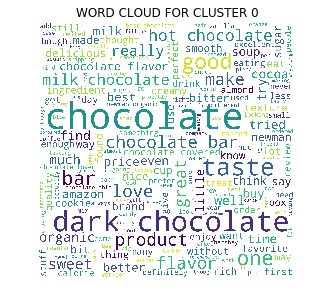

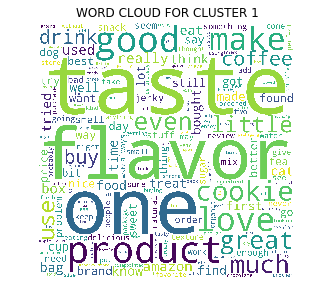

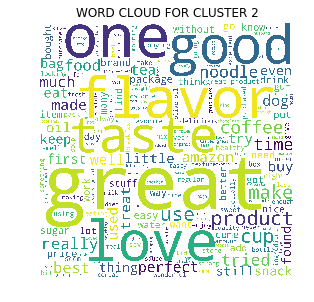

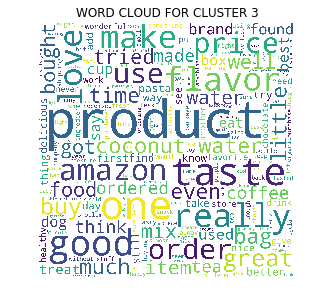

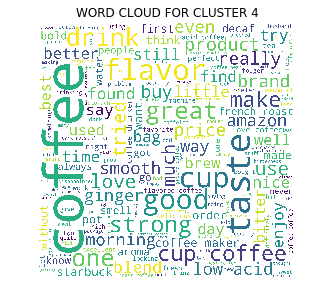

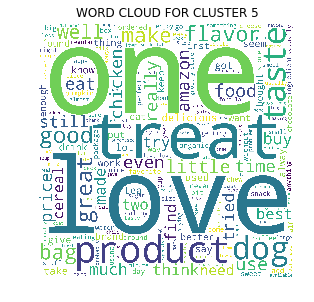

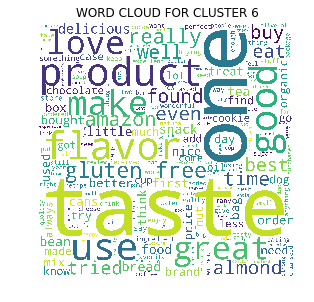

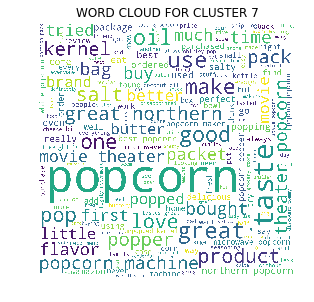

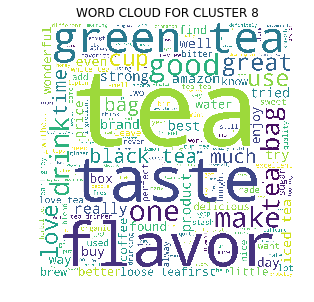

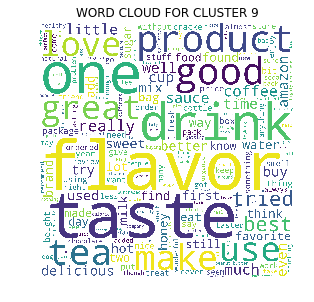

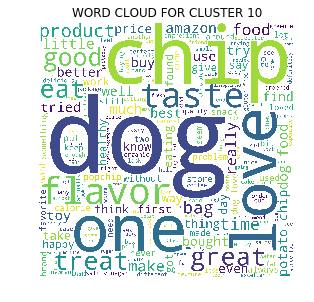

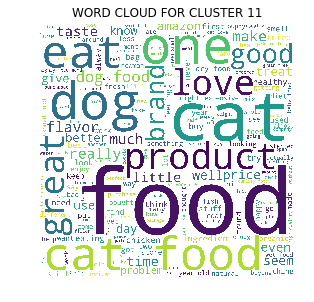

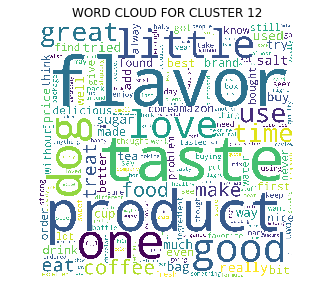

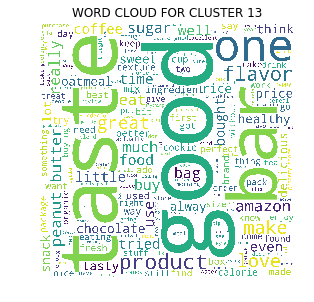

In [57]:
from wordcloud import WordCloud
for i in range(len(groups_cluster)):
    wc=WordCloud(width=4000,height=4000,stopwords=None,\
                           background_color='white',min_font_size=5).generate(groups_cluster[i])
    plt.figure()
    plt.imshow(wc)
    plt.axis('off')
    plt.title('WORD CLOUD FOR CLUSTER '+str(i))
    plt.tight_layout(pad=0)

    plt.show()

<h4> -In the above clusters, we can easily observe that there are some clusters similar to each other.<br>
     -There are also some words which are common in the clusters.<br>
    e.g., Product, Dog, Taste, good, etc.
</h4>

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [58]:
from sklearn.cluster import AgglomerativeClustering


In [73]:
model=[]
cluster=AgglomerativeClustering(n_clusters=2)
cluster.fit(sent_vectors_5k)
model.append(cluster)

cluster=AgglomerativeClustering(n_clusters=5)
cluster.fit(sent_vectors_5k)
model.append(cluster)

In [74]:
labels=cluster.labels_

### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

In [75]:
labels=model[0].labels_

In [76]:
final_5k['labels']=labels
groups_cluster=final_5k.filter(['Text','labels'],axis=1)

In [77]:
groups_cluster=groups_cluster.groupby('labels')['Text'].apply(lambda text: ','.join(text))

In [78]:
groups_cluster

labels
0    Why is this $[...] when the same product is av...
1    We have used the Victor fly bait for 3 seasons...
Name: Text, dtype: object

In [79]:
for i in range(len(groups_cluster)):
    groups_cluster[i]=prepro(groups_cluster[i])
    groups_cluster[i]=groups_cluster[i][0]
    

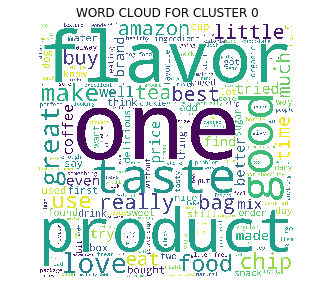

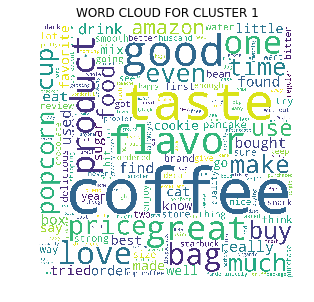

In [80]:
from wordcloud import WordCloud
for i in range(len(groups_cluster)):
    wc=WordCloud(width=4000,height=4000,stopwords=None,\
                           background_color='white',min_font_size=5).generate(groups_cluster[i])
    plt.figure()
    plt.imshow(wc)
    plt.axis('off')
    plt.title('WORD CLOUD FOR CLUSTER '+str(i))
    plt.tight_layout(pad=0)

    plt.show()

<h4> -In the above clusters, we can easily observe that there are some clusters similar to each other.<br>
     -There are also some words which are common in the clusters.<br>
    e.g., Product, good, love, great etc.
</h4>

In [81]:
labels=model[1].labels_

In [82]:
final_5k['labels']=labels
groups_cluster=final_5k.filter(['Text','labels'],axis=1)

In [83]:
groups_cluster=groups_cluster.groupby('labels')['Text'].apply(lambda text: ','.join(text))

In [84]:
groups_cluster

labels
0    The packaging is so cute on all of Ashby's tea...
1    Why is this $[...] when the same product is av...
2    We have been using this food for about 6 month...
3    I love Pico Pica.  It adds some flavor, and it...
4    We have used the Victor fly bait for 3 seasons...
Name: Text, dtype: object

In [85]:
for i in range(len(groups_cluster)):
    groups_cluster[i]=prepro(groups_cluster[i])
    groups_cluster[i]=groups_cluster[i][0]
    

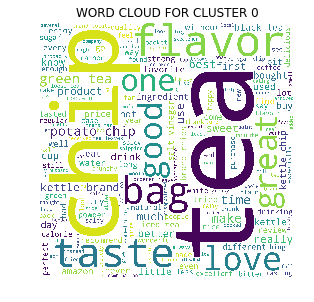

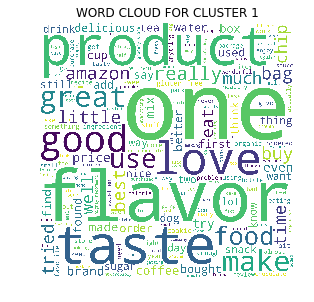

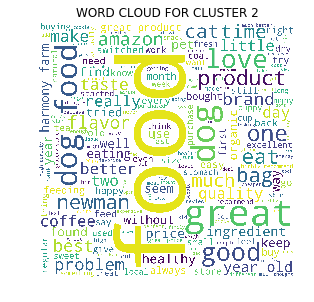

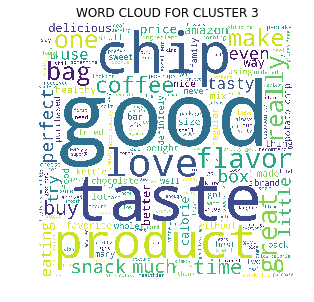

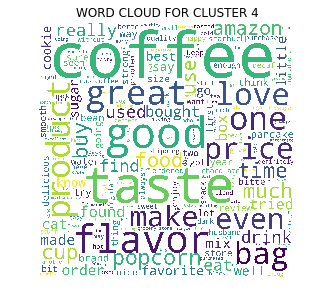

In [86]:
from wordcloud import WordCloud
for i in range(len(groups_cluster)):
    wc=WordCloud(width=4000,height=4000,stopwords=None,\
                           background_color='white',min_font_size=5).generate(groups_cluster[i])
    plt.figure()
    plt.imshow(wc)
    plt.axis('off')
    plt.title('WORD CLOUD FOR CLUSTER '+str(i))
    plt.tight_layout(pad=0)

    plt.show()

<h4> -In the above clusters, we can easily observe that there are some clusters similar to each other.<br>
     -There are also some words which are common in the clusters.<br>
    e.g., Product, good, Taste, Flavor etc.
</h4>

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [87]:
model=[]
cluster=AgglomerativeClustering(n_clusters=2)
cluster.fit(tfidf_sent_vectors_5k)
model.append(cluster)

cluster=AgglomerativeClustering(n_clusters=5)
cluster.fit(tfidf_sent_vectors_5k)
model.append(cluster)

In [88]:
labels=cluster.labels_

### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 4</font>

In [89]:
labels=model[0].labels_

In [90]:
final_5k['labels']=labels
groups_cluster=final_5k.filter(['Text','labels'],axis=1)

In [91]:
groups_cluster=groups_cluster.groupby('labels')['Text'].apply(lambda text: ','.join(text))

In [92]:
groups_cluster

labels
0    Why is this $[...] when the same product is av...
1    Though this coffee was expensive compared to r...
Name: Text, dtype: object

In [93]:
for i in range(len(groups_cluster)):
    groups_cluster[i]=prepro(groups_cluster[i])
    groups_cluster[i]=groups_cluster[i][0]
    

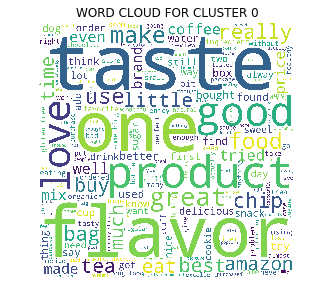

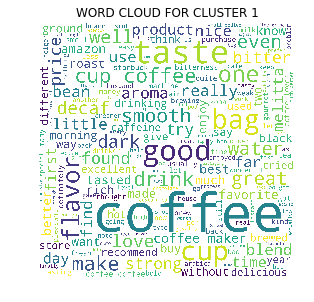

In [94]:
from wordcloud import WordCloud
for i in range(len(groups_cluster)):
    wc=WordCloud(width=4000,height=4000,stopwords=None,\
                           background_color='white',min_font_size=5).generate(groups_cluster[i])
    plt.figure()
    plt.imshow(wc)
    plt.axis('off')
    plt.title('WORD CLOUD FOR CLUSTER '+str(i))
    plt.tight_layout(pad=0)

    plt.show()

<h4> -In the above clusters, we can easily observe that there are some clusters similar to each other.<br>
     -There are also some words which are common in the clusters.<br>
    e.g., Product, good, flavor, love etc.
</h4>

In [95]:
labels=model[1].labels_

In [96]:
final_5k['labels']=labels
groups_cluster=final_5k.filter(['Text','labels'],axis=1)

In [97]:
groups_cluster=groups_cluster.groupby('labels')['Text'].apply(lambda text: ','.join(text))

In [98]:
groups_cluster

labels
0    Why is this $[...] when the same product is av...
1    This review will make me sound really stupid, ...
2    I have fallen in love with this tea. I am a br...
3    For people watching weight or nutrition,these ...
4    Though this coffee was expensive compared to r...
Name: Text, dtype: object

In [99]:
for i in range(len(groups_cluster)):
    groups_cluster[i]=prepro(groups_cluster[i])
    groups_cluster[i]=groups_cluster[i][0]

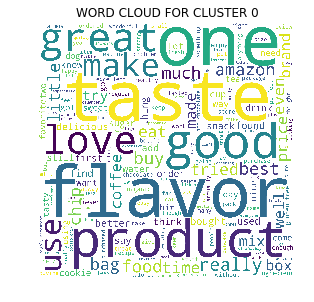

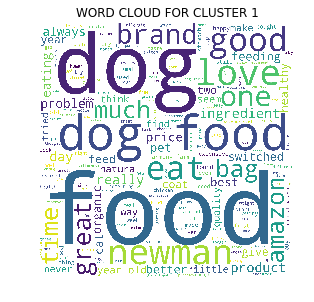

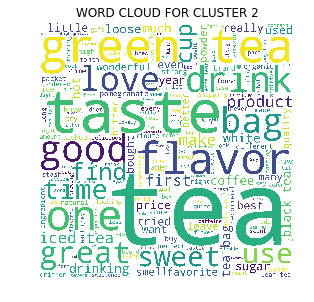

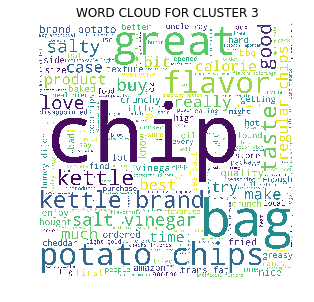

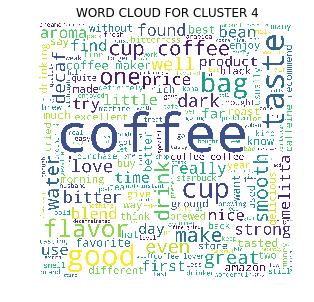

In [100]:
from wordcloud import WordCloud
for i in range(len(groups_cluster)):
    wc=WordCloud(width=4000,height=4000,stopwords=None,\
                           background_color='white',min_font_size=5).generate(groups_cluster[i])
    plt.figure()
    plt.imshow(wc)
    plt.axis('off')
    plt.title('WORD CLOUD FOR CLUSTER '+str(i))
    plt.tight_layout(pad=0)

    plt.show()

<h4> -In the above clusters, we can easily observe that there are some clusters similar to each other.<br>
     -There are also some words which are common in the clusters.<br>
    e.g., Great, Tea, Coffee, Dog, Product, good, etc.
</h4>

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [128]:
from sklearn.cluster import DBSCAN

In [66]:
from sklearn.neighbors import NearestNeighbors
max_distance = []

nn = NearestNeighbors(n_neighbors = 100)
nn.fit(sent_vectors_5k)
dist,ind = nn.kneighbors(n_neighbors = 100, return_distance = True)

for i,d in enumerate(dist):
    max_distance.append(d[-1])
max_distance.sort()
ind=np.arange(len(max_distance))

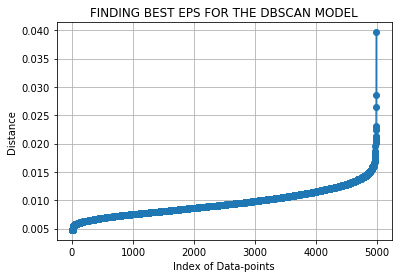

In [80]:
plt.plot(ind, max_distance,'o-')
plt.title("FINDING BEST EPS FOR THE DBSCAN MODEL")
plt.xlabel("Index of Data-points")
plt.ylabel("Distance")
plt.grid()
plt.show()

<p>TAKING EPS= 0.019,
AS IT IS LESS NOISY TO THE POINTS
</p>

In [147]:
cluster=DBSCAN(eps=0.019,min_samples=100)
cluster.fit(tfidf_sent_vectors_5k)
label = cluster.labels_

In [148]:
print('POINTS WITH LABEL',0,' i.e., NOT AN OUTLIER POINT',list(label).count(0))
print('POINTS WITH LABEL',-1,' i.e., AN OUTLIER POINT',list(label).count(-1))

POINTS WITH LABEL 0  i.e., NOT AN OUTLIER POINT 4971
POINTS WITH LABEL -1  i.e., AN OUTLIER POINT 15


### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

In [149]:
final_5k['labels']=cluster.labels_
groups_cluster=final_5k.filter(['Text','labels'],axis=1)

In [150]:
groups_cluster=groups_cluster.groupby('labels')['Text'].apply(lambda text: ','.join(text))

In [151]:
groups_cluster

labels
-1    These were shipped out the day after I ordered...
 0    Why is this $[...] when the same product is av...
Name: Text, dtype: object

In [153]:
groups_cluster[-1]=prepro(groups_cluster[-1])
groups_cluster[0]=prepro(groups_cluster[0])

In [154]:
groups_cluster[0]=groups_cluster[0][0]
groups_cluster[-1]=groups_cluster[-1][0]

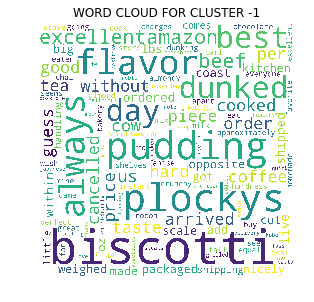

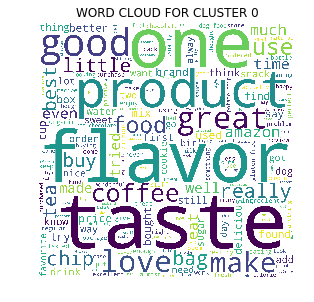

In [156]:
from wordcloud import WordCloud
for i in range(-1,1):
    wc=WordCloud(width=4000,height=4000,stopwords=None,\
                           background_color='white',min_font_size=5).generate(groups_cluster[i])
    plt.figure()
    plt.imshow(wc)
    plt.axis('off')
    plt.title('WORD CLOUD FOR CLUSTER '+str(i))
    plt.tight_layout(pad=0)

    plt.show()

<h4> -In the above clusters, we can easily observe that there are some clusters similar to each other.<br>
     -There are also some words which are common in the clusters.<br>
    e.g., taste, Food, Product, good, etc.
</h4>

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

In [104]:
from sklearn.cluster import DBSCAN

In [131]:
from sklearn.neighbors import NearestNeighbors

max_distance = []

nn = NearestNeighbors(n_neighbors = 100)
nn.fit(sent_vectors_5k)
dist,ind = nn.kneighbors(n_neighbors = 100, return_distance = True)

for i,d in enumerate(dist):
    max_distance.append(d[-1])
max_distance.sort()
ind=np.arange(len(max_distance))

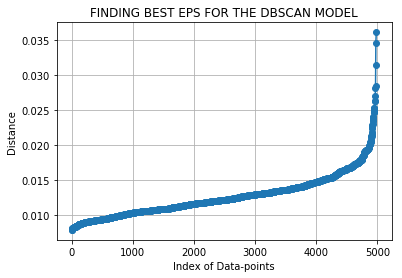

In [132]:
plt.plot(ind, max_distance,'o-')
plt.title("FINDING BEST EPS FOR THE DBSCAN MODEL")
plt.xlabel("Index of Data-points")
plt.ylabel("Distance")
plt.grid()
plt.show()

<p>TAKING EPS= 0.018,
AS IT IS LESS NOISY TO THE POINTS
</p>

In [88]:
cluster=DBSCAN(eps=0.018,min_samples=100)
cluster.fit(tfidf_sent_vectors_5k)
label = cluster.labels_

In [90]:
print('POINTS WITH LABEL',0,' i.e., NOT AN OUTLIER POINT',list(label).count(0))
print('POINTS WITH LABEL',-1,' i.e., AN OUTLIER POINT',list(label).count(-1))

POINTS WITH LABEL 0  i.e., NOT AN OUTLIER POINT 4964
POINTS WITH LABEL -1  i.e., AN OUTLIER POINT 22


### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

In [111]:
final_5k['labels']=cluster.labels_
groups_cluster=final_5k.filter(['Text','labels'],axis=1)

In [112]:
groups_cluster=groups_cluster.groupby('labels')['Text'].apply(lambda text: ','.join(text))

In [113]:
groups_cluster

labels
-1    These were shipped out the day after I ordered...
 0    Why is this $[...] when the same product is av...
Name: Text, dtype: object

In [109]:
# Combining all the above stundents 
def prepro(x):
    # Combining all the above stundents 
    from tqdm import tqdm
    preprocessed_reviews = []
    sentance=x
    # tqdm is for printing the status bar
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())
    return preprocessed_reviews

In [114]:
groups_cluster[-1]=prepro(groups_cluster[-1])
groups_cluster[0]=prepro(groups_cluster[0])

In [123]:
groups_cluster[0]=groups_cluster[0][0]
groups_cluster[-1]=groups_cluster[-1][0]

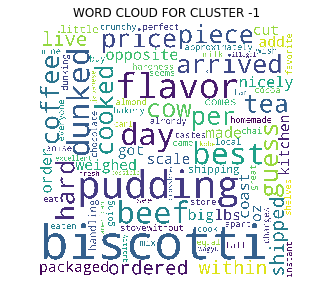

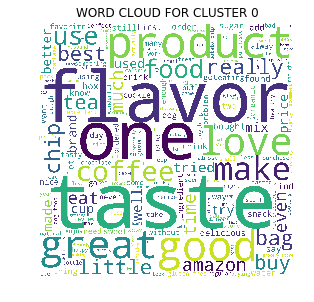

In [125]:
from wordcloud import WordCloud
for i in range(-1,1):
    wc=WordCloud(width=4000,height=4000,stopwords=None,\
                           background_color='white',min_font_size=5).generate(groups_cluster[0]=prepro(groups_cluster[0]))
    plt.figure()
    plt.imshow(wc)
    plt.axis('off')
    plt.title('WORD CLOUD FOR CLUSTER '+str(i))
    plt.tight_layout(pad=0)

    plt.show()

<h4>-There are also some words which are common in the clusters.<br>
    e.g., flavor, taste,coffee, good, etc.
</h4>

# [6] Conclusions

### FOR KMeans CLUSTERING

In [15]:
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["VECTORIZER", "HYPERMETER  'CLUSTER' ","NO. OF CLUSTER"]
x.add_row(["BOW",14,14])
x.add_row(["TFIDF",11,11])
x.add_row(["AVG W2V",14,14])
x.add_row(["TFIDF W2V",14,14])



In [16]:
print(x)

+------------+------------------------+----------------+
| VECTORIZER | HYPERMETER  'CLUSTER'  | NO. OF CLUSTER |
+------------+------------------------+----------------+
|    BOW     |           14           |       14       |
|   TFIDF    |           11           |       11       |
|  AVG W2V   |           14           |       14       |
| TFIDF W2V  |           14           |       14       |
+------------+------------------------+----------------+


### FOR AGGLOMERATIVE CLUSTERING

In [18]:
x = PrettyTable()
x.field_names = ["VECTORIZER", "HYPERMETER  'CLUSTER' ","NO. OF CLUSTER"]
x.add_row(["AVG W2V",[2,5],[2,5]])
x.add_row(["TFIDF W2V",[2,5],[2,5]])


In [19]:
print(x)

+------------+------------------------+----------------+
| VECTORIZER | HYPERMETER  'CLUSTER'  | NO. OF CLUSTER |
+------------+------------------------+----------------+
|  AVG W2V   |         [2, 5]         |     [2, 5]     |
| TFIDF W2V  |         [2, 5]         |     [2, 5]     |
+------------+------------------------+----------------+


### FOR DBSCAN CLUSTERING

In [81]:
x = PrettyTable()
x.field_names = ["VECTORIZER", "HYPERMETER  'eps' ","NO. OF CLUSTER"]
x.add_row(["AVG W2V",0.019,2])
x.add_row(["TFIDF W2V",0.018,2])


In [82]:
print(x)

+------------+--------------------+----------------+
| VECTORIZER | HYPERMETER  'eps'  | NO. OF CLUSTER |
+------------+--------------------+----------------+
|  AVG W2V   |       0.019        |       2        |
| TFIDF W2V  |       0.018        |       2        |
+------------+--------------------+----------------+
